# Calculations using CO2 EOS
- DiadFit includes the Span and Wagner (1996) and Sterner and Pitzer (1994) EOS.
- This allows lots of useful calculations to be performed which rely on these equation of states
- Spreadsheets we use- https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/Example7_Useful_EOS_Calcs/Batch_processing_TC.xlsx 
https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/Example7_Useful_EOS_Calcs/FI_densities.xlsx 

In [ ]:
#!pip install DiadFit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
# Make sure this reads at least 0.0.56
pf.__version__

'0.0.56'

## There are 3 main classes of calculations you can do using an EOS
- There are 3 variables related by the EOS, T, density and pressure. If you know 2 of these, you can calculate the third:
1) Calculate Pressure for a given T and CO$_2$ density, using the function 'calculate_P_for_rho_T', can use EOS='SP94' or 'SW96'

2) Calculate CO$_2$ density for a given P-T. using the function 'calculate_rho_for_P_T' with EOS='SP94' or 'SW96'

3) Calculate Temperature for a specified  CO$_2$ density and P using the function 'calculate_T_for_rho_P' with EOS='SP94' or 'SW96'


## You also have to use equation of states for microthermometry
4) calculate CO$_2$ density given a homogenization temp. This requires knowledge of the position of the L-V phase boundary. This is only currently supported in Span and Wanger (1996), using the function 'calculate_CO2_density_homog_T'


## Example 1 - Calculating Pressures from densities and entrapment temps
- The fundamental tenet of fluid inclusion barometry is that your inclusion has a fixed mass and volume. This means if you can get its density today in the lab using microthermometry or Raman Spectroscopy, and you can choose an entrapment temperature, you can calculate a pressure
- We can extrapolate along an isopleth using Span and Wanger (1996), or Sterner and Pitzer (1994)
- This uses the function 'calculate_P_for_rho_T'

- Lets perform the calculation for a single fluid inclusion

In [2]:
P_SW96=pf.calculate_P_for_rho_T(
CO2_dens_gcm3=0.5, T_K=1200, EOS='SP96')
P_SW96

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,1.721807,172.180688,1200,0.5


In [3]:
P_SP94=pf.calculate_P_for_rho_T(
CO2_dens_gcm3=0.5, T_K=1200, EOS='SP94')
P_SP94

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,1.756787,175.678735,1200,0.5


- Lets perform the calculation for an entire spreadsheet of fluid inclusions

In [4]:
df=pd.read_excel('FI_densities.xlsx')
P_kbar_SW96=pf.calculate_P_for_rho_T(
T_K=df['Temp in C']+273.15,
CO2_dens_gcm3=df['Density_g_cm3'],
EOS='SW96', Sample_ID=df['Sample'])
P_kbar_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3,Sample_ID
0,0.276826,27.682633,1373.15,0.1,FI1
1,1.559737,155.973743,1473.15,0.4,FI2
2,3.789037,378.903651,1423.15,0.7,FI3
3,10.626112,1062.611174,1473.15,1.1,FI4
4,26.062249,2606.224906,1573.15,1.5,FI5


- Lets convert these pressures into depths using the Ryan-Lerner density profile
- Note, Nans are returned for pressures outside the calibration range of this model

In [5]:
RL_D=pf.convert_pressure_to_depth(P_kbar=P_kbar_SW96['P_kbar'],
model='ryan_lerner')
RL_D

0     1.256957
1     6.419763
2    14.157451
3          NaN
4          NaN
dtype: float64

- Lets make synthetic data across a range of temperatures and densities (between 0-2000 K, 0.1 and 1.1 g/cm3) to visualize how pressure and temperature are related

In [7]:
# Chose an array of temperatures in celcius
T_C=np.linspace(0, 2000, 100)
# Convert to Kelvin
T_K=T_C+273.15
# Choose an array of densities (g/cm3)
rho_lin=np.linspace(1.1, 0.1, 11)

# Now write a loop to fill out a pressure array
Pressure_SP94=np.empty([len(rho_lin), len(T_K)], float)
Pressure_SW96=np.empty([len(rho_lin), len(T_K)], float)
for i in range(0, len(rho_lin)):
    P_SW96=pf.calculate_P_for_rho_T(CO2_dens_gcm3=rho_lin[i], T_K=T_K, EOS='SW96').P_kbar
    Pressure_SW96[i, :]=P_SW96
    P_SP94=pf.calculate_P_for_rho_T(CO2_dens_gcm3=rho_lin[i], T_K=T_K, EOS='SP94').P_kbar
    Pressure_SP94[i, :]=P_SP94
    

### plot for a single EOS

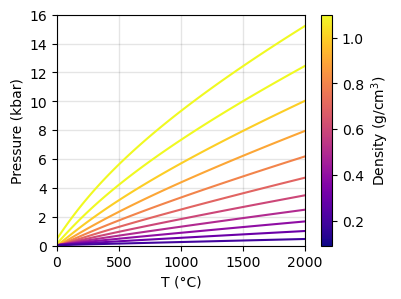

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,3), sharex=True, sharey=True)
import matplotlib.colors as colors
#ax1.plot(T_C, P_kbar, '-r')
import matplotlib.cm as cm
for i in range(0, len(rho_lin)):
    color=cm.plasma(rho_lin[i])
    ax1.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
 

norm = colors.Normalize(vmin=rho_lin[0], vmax=rho_lin[-1])
sm = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label('Density (g/cm$^3$)')



ax1.set_ylabel('Pressure (kbar)')
#legend = ax1.legend(loc='upper left', ncol=2, frameon=True, fontsize=7)
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 16])

ax1.set_xlabel('T (°C)')
ax1.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)

fig.savefig('EOS.png', dpi=200, bbox_inches='tight')

### Plot comparing different EOS

Text(0.5, 1.0, 'Comparing ST1994 and SP1996')

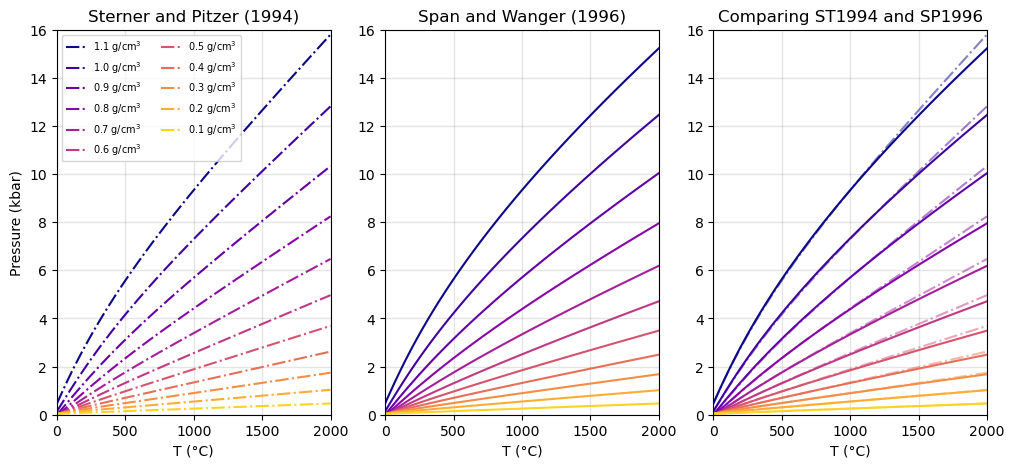

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5), sharex=True, sharey=True)
#ax1.plot(T_C, P_kbar, '-r')
import matplotlib.cm as cm
for i in range(0, len(rho_lin)):
    color=cm.plasma(i/len(rho_lin))
    ax1.plot(T_C, Pressure_SP94[i, :], '-.',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    ax2.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    
    ax3.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    ax3.plot(T_C, Pressure_SP94[i, :], '-.',  
    color=color, label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$', alpha=0.5)
    

ax1.set_ylabel('Pressure (kbar)')
legend = ax1.legend(loc='upper left', ncol=2, frameon=True, fontsize=7)
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 16])
ax2.set_xlabel('T (°C)')
ax3.set_xlabel('T (°C)')
ax1.set_xlabel('T (°C)')
ax1.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)
ax2.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)
ax3.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
ax3.yaxis.set_tick_params(which='both', labelbottom=True)
ax1.set_title('Sterner and Pitzer (1994)')
ax2.set_title('Span and Wanger (1996)')
ax3.set_title('Comparing ST1994 and SP1996')

## Example 2 - Calculating density for given Pressure and temperature

- Lets do the calculation firstly for one pressure and temperature we are interested in
- You could also load in a spreadsheet as before

In [12]:
SW96_rho=pf.calculate_rho_for_P_T(P_kbar=1, 
T_K=1400, EOS='SW96')
SW96_rho

0    0.300608
dtype: float64

- Or for lots and lots of different pressures, to see how density changes with pressure at fixed temperatures

In [13]:
P_kbar_linspace=np.linspace(0.01, 10, 50)
SW96_Parray_1400=pf.calculate_rho_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1400, EOS='SW96')
SP94_Parray_1400=pf.calculate_rho_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1400, EOS='SP94')

SW96_Parray_1200=pf.calculate_rho_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1200, EOS='SW96')
SP94_Parray_1200=pf.calculate_rho_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1200, EOS='SP94')


Text(0, 0.5, 'Density SW96-SP94 (g/cm3)')

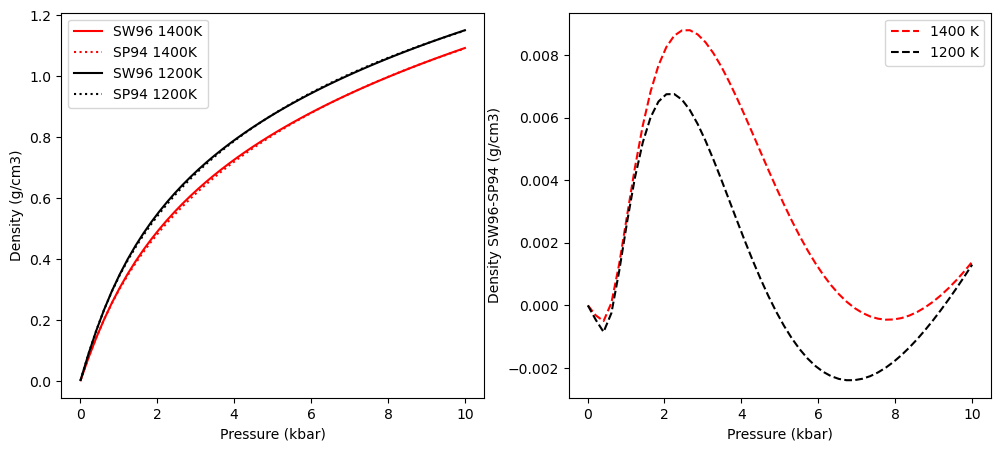

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)

ax1.plot(P_kbar_linspace, SW96_Parray_1400, '-r', label='SW96 1400K')
ax1.plot(P_kbar_linspace, SP94_Parray_1400, ':r', label='SP94 1400K')


ax1.plot(P_kbar_linspace, SW96_Parray_1200, '-k', label='SW96 1200K')
ax1.plot(P_kbar_linspace, SP94_Parray_1200, ':', color='k', label='SP94 1200K')
ax1.legend()

ax2.plot(P_kbar_linspace, SW96_Parray_1400-SP94_Parray_1400, '--r', label='1400 K')
ax2.plot(P_kbar_linspace, SW96_Parray_1200-SP94_Parray_1200, '--k', label='1200 K')
ax2.legend()


ax1.set_xlabel('Pressure (kbar)')
ax1.set_ylabel('Density (g/cm3)')

ax2.set_xlabel('Pressure (kbar)')
ax2.set_ylabel('Density SW96-SP94 (g/cm3)')

## Example 3 - Calculating temperature for a known density and pressure
- This function behaves the same as the previous 2 discussed, here we show a single calculation, it could also be applied to a spreadsheet

In [15]:
SW96_T=pf.calculate_T_for_rho_P(CO2_dens_gcm3=0.3, P_kbar=1, 
 EOS='SW96')
SW96_T

0    1403.252835
dtype: float64

In [16]:
SP94_T=pf.calculate_T_for_rho_P(CO2_dens_gcm3=0.3, P_kbar=1, 
 EOS='SP94')
SP94_T

0    1389.233164
dtype: float64

## Example 4: Calculating densities in 2 phase bubbles at room temp
- We have parameterized the L-V curve using the Span and Wanger (1996) EOS. 
- This means you can enter a temperature, and find out what the density of the CO$_2$ gas and liquid would be for an inclusion following the L-V curve on the phase diagram

 - This can be very useful, because if you are conducting Raman analyses at room temperature for bubbles with densities higher than the critical density, you will only analyse the interior gas (with complex interactions with the liquid phase, see DeVitre et al. 2023, Volcanica).
 


In [17]:
 # Lets consider 'room Temps' between 18 and 23C using Span and Wagner 1996
Temps=np.linspace(17, 25)
df_roomT_SW96=pf.calculate_CO2_density_homog_T(T_h_C=Temps, EOS='SW96')
df_roomT_SW96.tail()

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to
45,NaN,0.720108,0.234969,24.346939,None
46,NaN,0.717753,0.236851,24.510204,None
47,NaN,0.715363,0.238767,24.673469,None
48,NaN,0.712936,0.240719,24.836735,None
49,NaN,0.710471,0.242710,25.000000,None


Text(0, 0.5, 'Gas density (g/cm3)')

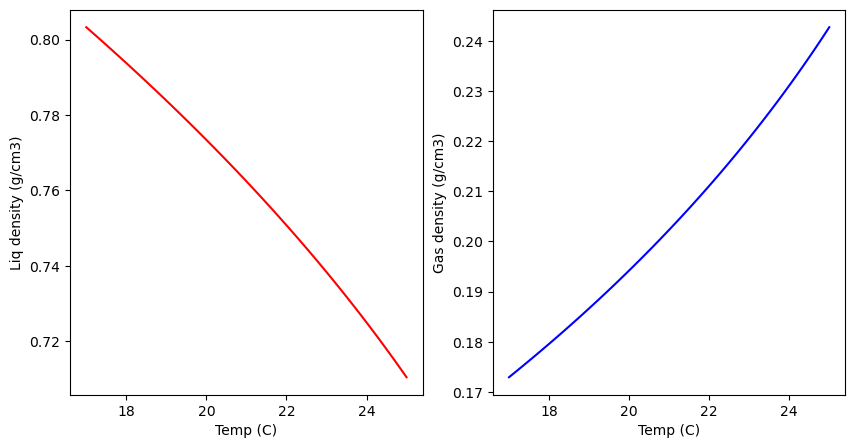

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Temps, df_roomT_SW96['Liq_gcm3'], '-r', label='SW96')
ax2.plot(Temps, df_roomT_SW96['Gas_gcm3'], '-b', label='SW96')

ax1.set_xlabel('Temp (C)')
ax1.set_ylabel('Liq density (g/cm3)')
ax2.set_xlabel('Temp (C)')
ax2.set_ylabel('Gas density (g/cm3)')

## Example 5 - Calculating homogenization temperatures from microthermometry
- Microthermometry works by cooling CO$_2$ rich fluid inclusions down, and then heating up until the liquid and gas homogenizes to a single phase. This gives you the density of CO2. You can then calculate the pressure by extrapolating 
- Again, we use the Span and Wagner (1996) EOS. We note that some existing spreadsheets use the L-V curve from Span and Wanger, but extrapolate using Sterner and Pitzer (1994). We do not wish to mix and match EOS, so use SW96 for the L-V curve and extrapolating along the isochore

- Lets perform calcs for one FI, e.g. while we are on the microscope and are very excited to get the density!
- Say we see the homogenization at -18C, and it homogenizes to a liquid, we know the density is 1.022 g/cm3

In [21]:
Density1=pf.calculate_CO2_density_homog_T(T_h_C=-18, Sample_ID='FI2',
                            homog_to='L', EOS='SW96')
Density1

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to,Sample_ID
0,1.022329,1.022329,0.055156,-18,L,FI2


### Lets load an entire day of microthermometry results, and calculate density for all at once

In [22]:
homog_t=pd.read_excel('Batch_processing_TC.xlsx')
homog_t.head()

Whole_day_dens=pf.calculate_CO2_density_homog_T(T_h_C=homog_t['T_c_Homog'],
            Sample_ID=homog_t['Sample'], homog_to=homog_t['homog_to'], EOS='SW96')
Whole_day_dens.head()

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to,Sample_ID
0,0.593263,0.593263,0.345003,30,L,FI1
1,0.710471,0.710471,0.242710,25,L,FI2
2,0.773392,0.773392,0.194204,20,L,FI3
3,0.160735,0.821187,0.160735,15,V,FI4
4,0.861096,0.861096,0.135157,10,L,FI5


### Propagating errors in microthermometry
- Lets say we measure a homogenization temp of -30 C, but there is a 0.3 C error on our stage temp, or we werent exactly sure when the bubble disapeared
- N dup says how many monte carlo simulations we are going to do. Lets say 1000. 

In [27]:
# First calculate density
Av_outputs_SW96, All_outputs_SW96=pf.propagate_microthermometry_uncertainty(T_h_C=-30, 
Sample_ID='test', error_T_h_C=0.3, N_dup=1000,
EOS='SW96', homog_to='L',
error_dist_T_h_C='normal', error_type_T_h_C='Abs')

### Lets inspect the outputs

In [28]:
Av_outputs_SW96.head()

,Sample_ID,Mean_density_Gas_gcm3,Std_density_Gas_gcm3,Mean_density_Liq_gcm3,Std_density_Liq_gcm3,error_T_h_C
0,test,0.037095,0.00037,1.075807,0.001239,0.3


In [29]:
All_outputs_SW96.head()

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to,Sample_ID
0,1.074665,1.074665,0.037436,-29.735269,L,test
1,1.075960,1.075960,0.037048,-30.041396,L,test
2,1.074881,1.074881,0.037371,-29.786233,L,test
3,1.073442,1.073442,0.037804,-29.446810,L,test
4,1.078037,1.078037,0.036431,-30.533959,L,test


### Lets plot up these outputs

Text(0.5, 0, 'gas (g/cm3)')

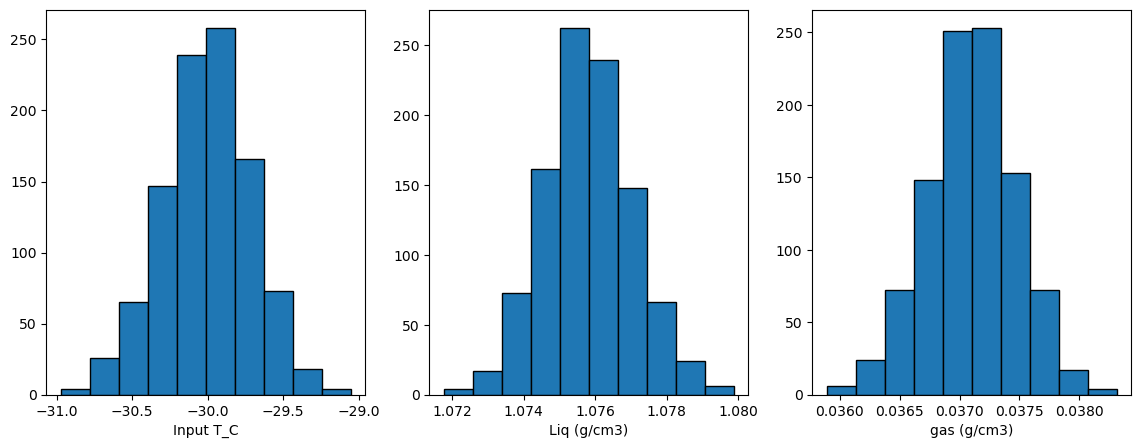

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14,5))
ax0.hist(All_outputs_SW96['T_h_C'], ec='k');
ax1.hist(All_outputs_SW96['Liq_gcm3'], ec='k');
ax2.hist(All_outputs_SW96['Gas_gcm3'], ec='k');
ax0.set_xlabel('Input T_C')
ax1.set_xlabel('Liq (g/cm3)')
ax2.set_xlabel('gas (g/cm3)')